<a href="https://colab.research.google.com/github/Whoseyashar/Machine-Learning-Advance/blob/main/GNN_Attentions_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Graph Attention Networks (GATs) are a theoretical improvement over GCNs. Instead of static normalization coefficients, they propose weighting factors calculated by a process called self-attention. The same process is at the core of one of the most successful deep learning architectures: the transformer, popularized by BERT and GPT-3. Introduced by Veličković et al. in 2017, GATs have become one of the most popular GNN architectures thanks to excellent out-of-the-box performance.

To understand how attention values are calculated at each step we need to build the matrices by ourselves and build graph attention layer from scratch.

And that is exactly what we are going to do.

Later, you will be able to implement GAT in PyTorch Geometric (PyG). Thus learning about the performance differences between this architecture and a GCN.

The main idea behind GATs is that some nodes are more important than others. In fact, this was already the case with the graph convolutional layer: nodes with few neighbors were more important than others, thanks to the normalisation coefficient:

$\frac{1}{\sqrt{deg(i)} \sqrt{deg(j)}}$

This approach is limiting because it only takes into account node degrees. On the other hand, the goal of the graph attention layer is to produce weighting factors that also consider the importance of node features.

Let’s call our weighting factors attention scores and note the attention weight as $a_{ij}$ (the attention score between the nodes $i$ and $j$). We can define the graph attention operator as follows:

$h_i = \sum_{j ϵ N_i}^{} a_{ij} W x_j$

An important characteristic of GATs is that the attention scores are calculated implicitly by comparing inputs to each other (hence the name self-attention). To calculate these attention scores four steps are necessary (also these steps can be optimised if you decide to build your own models once you learn how to do it from scratch).

# Linear transformation

The attention score represents the importance between a central node $i$ and a neightbor $j$. It requires node features from both bodes. In the graph attention layer, it is achived by a concatenation between the hidden vectors $Wx_i$ and $Wx_j$:

[ $Wx_i$ || $Wx_j$ ]

Where $W$ is a classic shared weight matrix to compute hidden vectors. An additional linear transformation is applied to this result with a dedicated learnable weight matrix $W_{att}$.

During training, this matrix will learn weights to produce attention coefficients $a_{ij}$. Summerised in the following formula is matrix multiplication:

$a_{ij} = W^T_{att}$ [ $Wx_i$ || $Wx_j$ ]

Next, feeding the output to the activation function like in the standard NNs.


# Activation function

Nonlinearity is an essential component in neural networks to approximate nonlinear target functions. Such functions could not be captured by simply stacking linear layers, as their final outcome would still behave like a single linear layer.

In the original paper, the authors use the Leaky Rectified Linear Unit (ReLU) activation function. So what we need to do is to apply the Leaky ReLU function to the output of the previous step:

$e_{ij} = LeakyReLU(a_{ij})$

However, we are now facing a new problem: the resulting values are not normalized!
    

# Softmax normalization

We want to compare different attention scores, which means we need normalized values on the same scale. In machine learning, it is common to use the softmax function for this purpose. If we call $N_i$ the neighboring nodes of node $i$, including itself:

$a_{ij} = softmax_j(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k ϵ N_i} exp(e_{ik})}$

The result of the operation is the final attention score $a_{ij}$.



# Multi-head attention

There’s another problem: self-attention is not very stable.

This issue was already noticed by Vaswani et al. (2017) in the original transformer paper. Their proposed solution consists of calculating multiple embeddings with their own attention scores instead of a single one. This technique is called multi-head attention.

The implementation is straightforward, as we just have to repeat the three previous steps multiple times. Each instance produces an embedding $h^k_i$, where $k$ is the index of the attention head. There are two ways of combining the results, to concatenate or average:

$h_i = \frac{1}{n} \sum^n_{k = 1} h^k_i = \frac{1}{n} \sum^n_{k = 1} \sum_{j ϵ N_i} a^k_{ij} W^k x_j$


The first step towards implementing all theoretical parts mentioning above in bare NumPy is to translate graph attention operatos in terms of matrices. Where matrix multiplication looks like this:

$H = Ã^T W_a XW^T$

Where $W_a$ is a matrix that stores every $a_{ij}$. For all previous notations, refer to the previous exercises.

Lets start with implementation and debugging..

In [1]:
import numpy as np

np.random.seed(0)  # lets set up seed such as that our results can be deterministic

# let's manually build adjacency matrix of 4 nodes and create neighborhood
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])
print(f'A={A}')  # we can print so to ease the visualisation part
print()

# next we create feature matrix. Let's make it as a random matrix of node features
# of dimension (number of nodes x number of features)
X = np.random.uniform(-1, 1, (4, 4))
print(f'X={X}')
print()

# The next step is to define our weight matrices.
# There are two of them we defined in the theoretical part:
# a) The regular weight matrix.
# of dimensions (number of hidden dimensions x number of nodes)
W = np.random.uniform(-1, 1, (2, 4)) # lets choose 2 hidden dimensions in thise example
print(f'W={W}')
print()

# b) The attention weight matrix.
# This attention matrix is applied to the concatenation of hidden vectors to produce a unique value.
# Dimensions: (1, number of hidden dimensions x 2)
W_att = np.random.uniform(-1, 1, (1, 4))  # pay attention it has 1 dimension by (hidden_dimensions X 2), in our example 2 x 2 = 4
print(f'W_att={W_att}')
print()

# We want to concatenate hidden vectors from source and destination nodes.
# A simple way to obtain pairs of source and destination nodes is to look at our adjacency matrix Ā in COO format:
# rows store source nodes, and columns store destination nodes.
# NumPy provides a quick and efficient way of doing it with np.where()
connections = np.where(A > 0)
print(f'connections={connections}')
print()

# After obtaining connections we need to concatena hidden vectors of source and destination nodes
# following formula, our concatibation looks like this:
# a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1).T
# yet lets break it step by step

# First, we perform linear transformation of feature vector and weight matrix
x_w_T = X @ W.T
print('x_w_T = X @ W.T')
print(f'X_W.T={x_w_T}')
print()

# Next we specify rows (nodes features) to be used in the tranformation/multiplication based on the source and destination arrays
x_w_T_source_selected = x_w_T[connections[0]]
print('x_w_T_source_selected = x_w_T[connections[0]]')
print(f'X_W.T_source_selected={x_w_T_source_selected}')
print()

x_w_T_destination_selected = x_w_T[connections[1]]
print('x_w_T_destination_selected = x_w_T[connections[1]]')
print(f'X_W.T_destination_selected={x_w_T_destination_selected}')
print()

# Next, we concatenate hidden vectors of source and destination nodes
x_concat = np.concatenate([x_w_T_source_selected, x_w_T_destination_selected], axis=1)
print('x_concat = np.concatenate([x_w_T_source_selected, x_w_T_destination_selected], axis=1)')
print(f"Concatenations based on the source and destination vectors: {x_concat}")
print()
# We then apply a linear transformation to this result with the attention matrix
a = W_att @ x_concat.T
print('a = W_att @ x_concat.T')
print(f'a={a}')
print()

# Next step from the theoretical part is to apply a Leaky ReLU activation function to the previous outcome:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha * x, x)


# lets make vectors diferentiable
e = leaky_relu(a)
print(f'Leaky_relu={e}')
print()

# At this moment, we have the right values but need to place them correctly in a matrix to be assigned to right nodes
# This matrix should look like Ā, because there is no need for unnormalized attention scores when there is no connection between two nodes.
E_attention_scores = np.zeros(A.shape)
print(f'E={E_attention_scores}')
print()
E_attention_scores[connections[0], connections[1]] = e[0]
print(f'E={E_attention_scores}')
print()

# The next step is to normalize every row of attention scores. This requires a custom softmax function to produce our final attention scores
def softmax2D(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis)
    return e / sum


W_alpha = softmax2D(E_attention_scores, 1) # This attention matrix provides weights for every possible connection in the network.
print(f'W_alpha={W_alpha}')
print()

# We can use the previous attention matrix W_a to calculate matrix of embeddings H, which should give two-dimensional vectors for each node:
H = A.T @ W_alpha @ X @ W.T
print('H = A.T @ W_alpha @ X @ W.T')
print(f'H={H}')
print()

# Our graph attention layer is now complete!
# Adding multi-head attention consists of repeating these steps with different W and W_att before aggregating the results.

# The graph attention operator is an essential building block to developing GNNs.



A=[[1 1 1 1]
 [1 1 0 0]
 [1 0 1 1]
 [1 0 1 1]]

X=[[ 0.09762701  0.43037873  0.20552675  0.08976637]
 [-0.1526904   0.29178823 -0.12482558  0.783546  ]
 [ 0.92732552 -0.23311696  0.58345008  0.05778984]
 [ 0.13608912  0.85119328 -0.85792788 -0.8257414 ]]

W=[[-0.95956321  0.66523969  0.5563135   0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835]]

W_att=[[-0.76345115  0.27984204 -0.71329343  0.88933783]]

connections=(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

x_w_T = X @ W.T
X_W.T=[[ 0.37339233  0.38548525]
 [ 0.85102612  0.47765279]
 [-0.67755906  0.73566587]
 [-0.65268413  0.24235977]]

x_w_T_source_selected = x_w_T[connections[0]]
X_W.T_source_selected=[[ 0.37339233  0.38548525]
 [ 0.37339233  0.38548525]
 [ 0.37339233  0.38548525]
 [ 0.37339233  0.38548525]
 [ 0.85102612  0.47765279]
 [ 0.85102612  0.47765279]
 [-0.67755906  0.73566587]
 [-0.67755906  0.73566587]
 [-0.67755906  0.73566587]
 [-0.65268413  0.24235977]
 [-0.

# Implementing GAT in Pytorch

We now have a complete picture of how the graph attention layer works and how to obtain attention scores for training. These layers can be stacked to create our new architecture of choice: the GAT. The following code represent the guidelines from the original GAT paper to implement our own model using PyG.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00


Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Epoch   0 | Train Loss: 1.969 | Train Acc: 17.86% | Val Loss: 1.96 | Val Acc: 15.40%
Epoch  20 | Train Loss: 0.191 | Train Acc: 98.57% | Val Loss: 0.94 | Val Acc: 70.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 97.86% | Val Loss: 0.85 | Val Acc: 74.20%
Epoch  60 | Train Loss: 0.144 | Train Acc: 97.86% | Val Loss: 0.88 | Val Acc: 73.60%
Epoch  80 | Train Loss: 0.176 | Train Acc: 98.57% | Val Loss: 0.87 | Val Acc: 76.20%
Epoch 100 | Train Loss: 0.183 | Train Acc: 96.43% | Val Loss: 0.88 | Val Acc: 73.80%
GAT test accuracy on Cora: 82.00%


Processing...
Done!


Epoch   0 | Train Loss: 1.851 | Train Acc: 13.33% | Val Loss: 1.83 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.133 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 61.80%
Epoch  40 | Train Loss: 0.138 | Train Acc: 97.50% | Val Loss: 1.15 | Val Acc: 61.80%
Epoch  60 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 1.16 | Val Acc: 63.60%
Epoch  80 | Train Loss: 0.138 | Train Acc: 99.17% | Val Loss: 1.11 | Val Acc: 63.80%
Epoch 100 | Train Loss: 0.128 | Train Acc: 98.33% | Val Loss: 1.20 | Val Acc: 60.40%
GAT test accuracy on CiteSeer: 68.10%


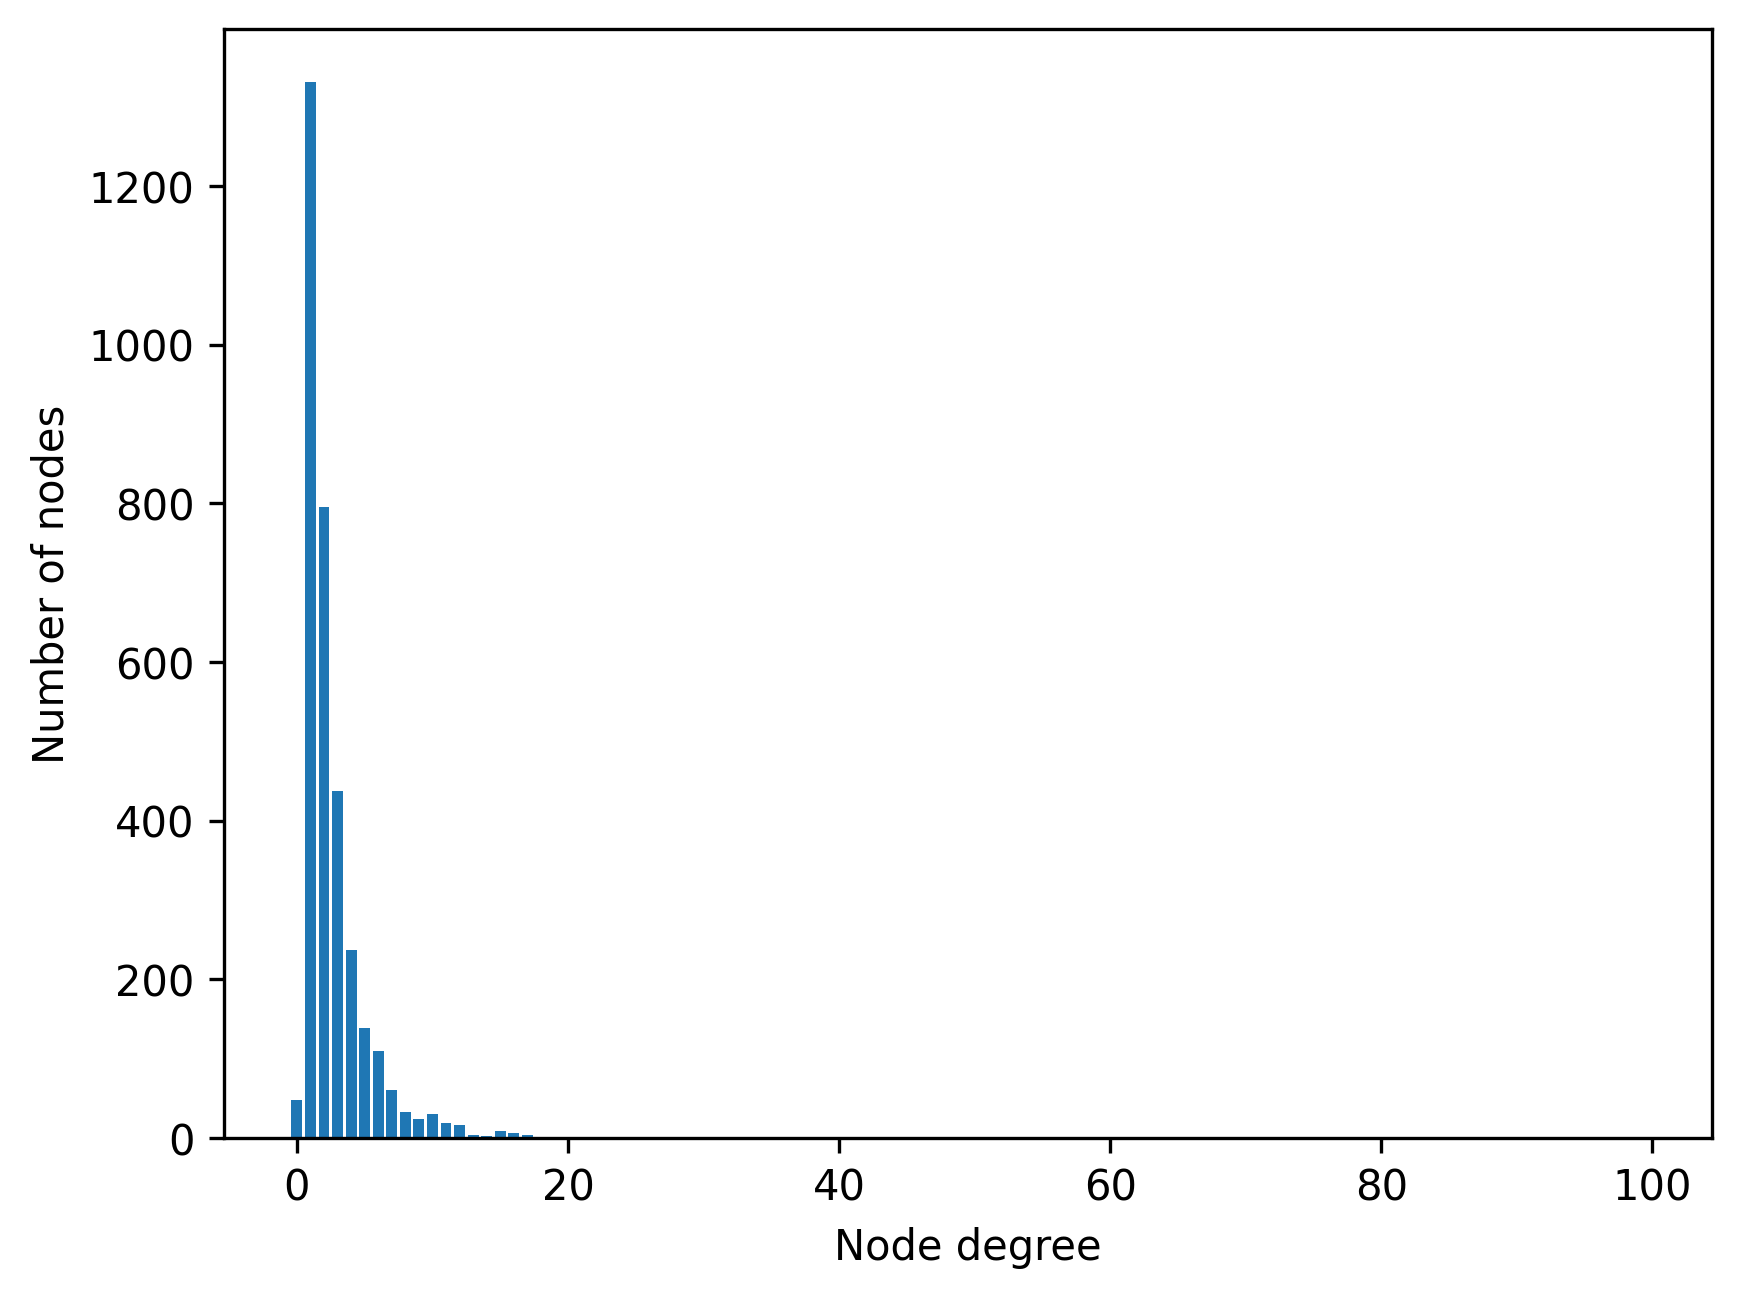

In [2]:
!pip install torch_geometric
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv


def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)


class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)
        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if (epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc * 100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc * 100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

dataset = Planetoid(root="./datasets/", name="Cora")
data = dataset[0]

print(data)

gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat.fit(data, epochs=100)

acc = gat.test(data)
print(f'GAT test accuracy on Cora: {acc * 100:.2f}%')

dataset = Planetoid(root="./datasets/", name="CiteSeer")
data = dataset[0]

gat = GAT(dataset.num_features, 16, dataset.num_classes)
gat.fit(data, epochs=100)

acc = gat.test(data)
print(f'GAT test accuracy on CiteSeer: {acc * 100:.2f}%')

import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter
import numpy as np

degrees = degree(dataset[0].edge_index[0]).numpy()
numbers = Counter(degrees)
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())
plt.show()


According to Schur et al. in Pitfalls of Graph Neural Network Evaluation, the GAT is slightly better than the GCN (82.8% ± 0.6% versus 81.9% ± 0.8%) on Cora and CiteSeer (71.0 ± 0.6% versus 69.5% ± 0.9%). The authors also note that the accuracy scores are not normally distributed, making the usage of standard deviation less relevant. It is important to keep that in mind in this type of benchmark.

Previously, We speculated that poorly connected nodes might negatively impact performance. We can verify this hypothesis by plotting the average accuracy score for each node degree:

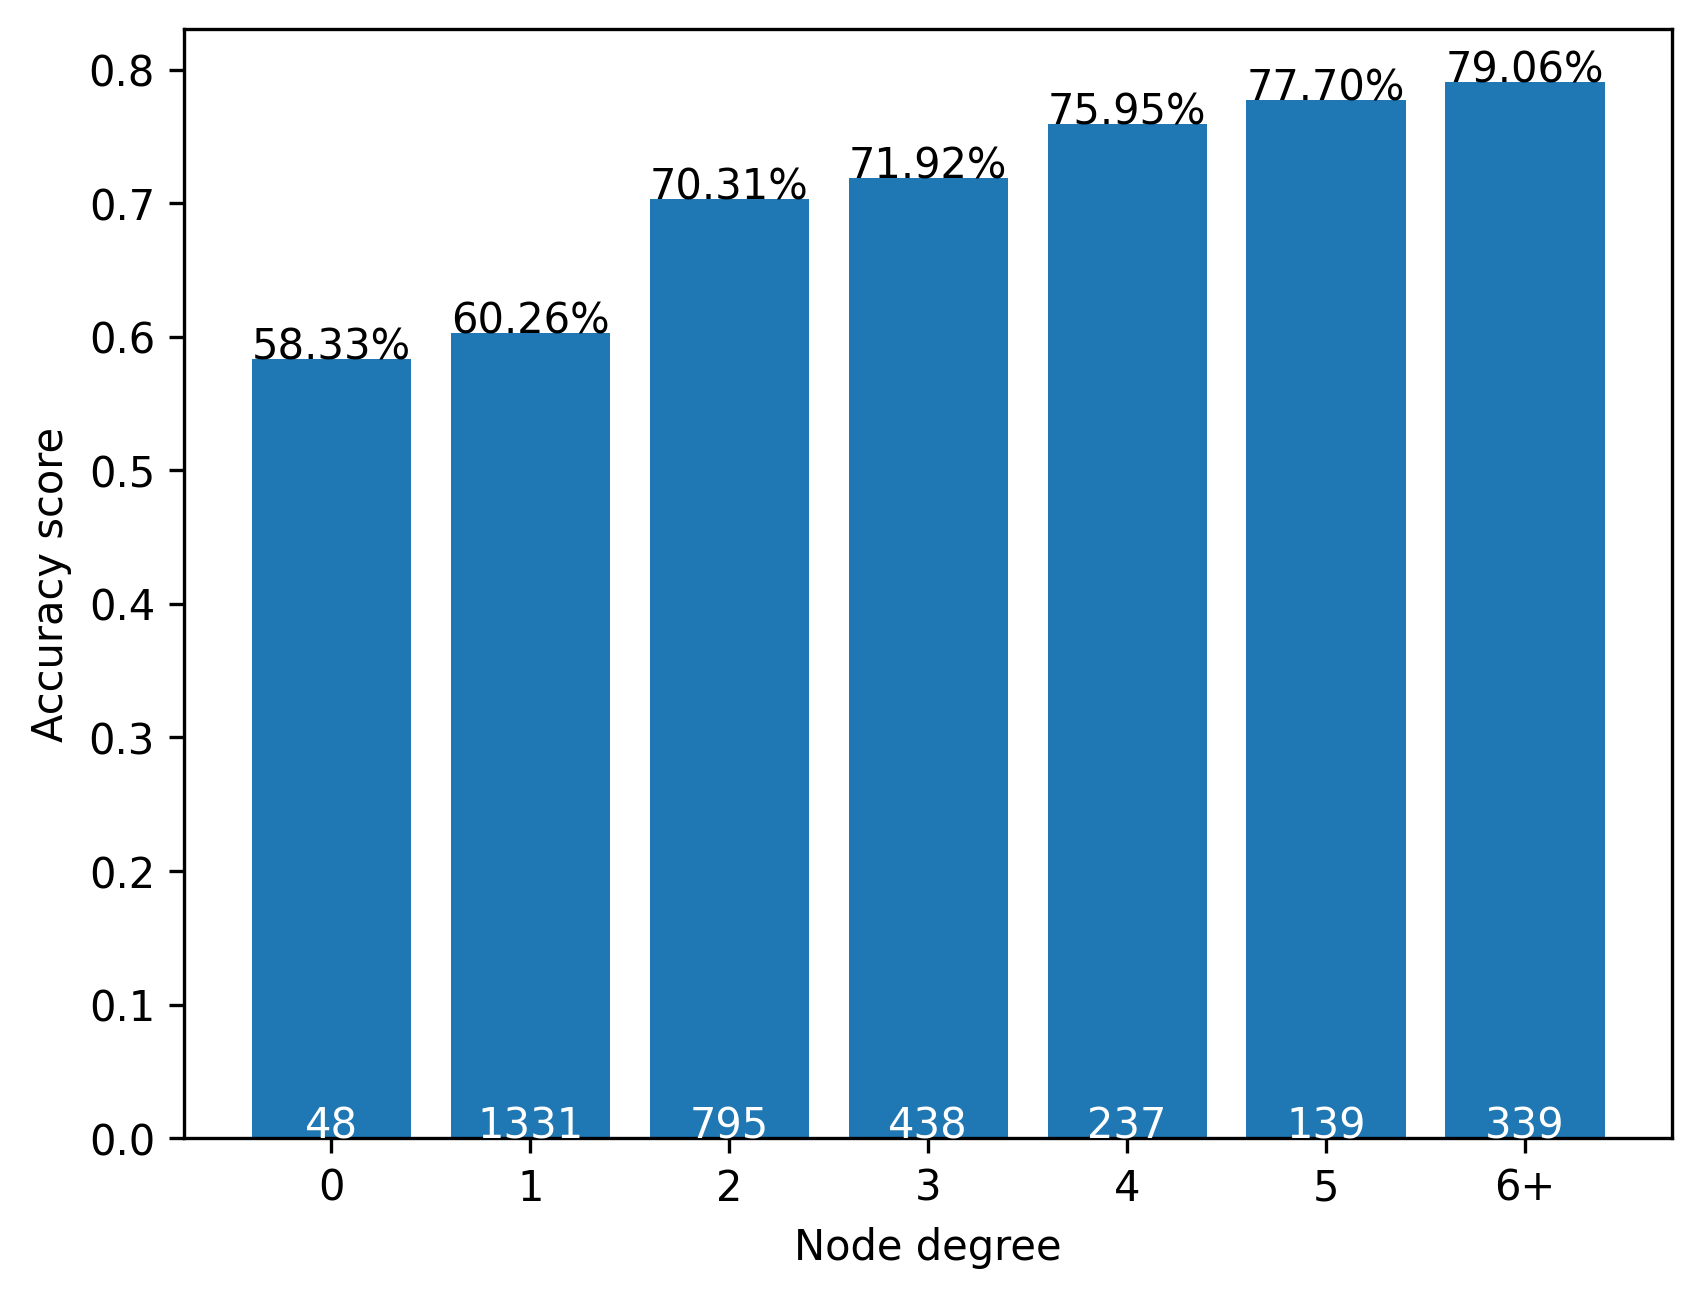

In [3]:
out = gat(data.x, data.edge_index) # get the model classification

degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes = []

for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0', '1', '2', '3', '4', '5', '6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i] * 100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i] // 2, sizes[i], ha='center', color='white')

plt.show()

# Nodes with few neighbors are harder to classify correctly.
# Furthermore, it even shows that, in general, the higher the node degree, the better the accuracy score.
# This is quite natural because a higher number of neighbors will provide more information to the GNN to make its predictions.
